# Optimalno upravljanje - Domaci 1 - Optimalno upravljanje modelom akutne mijeloidne leukemije

## Biblioteke

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Definisanje parametara

In [14]:
rho_s = 0.5
rho_a = 0.43
rho_l = 0.27

delta_s = 0.5
delta_a = 0.44
delta_l = 0.275

mi_d = 0.275
mi_t = 0.3

K1 = 1
K2 = 1

alpha = 0.015
gamma = 0.01

t_start = 0
t_stop = 50
T_sample = 0.001

a1 = 1
a2 = 1
w = 0.9

## Pocetni uslovi

In [15]:
S0 = 0.72
A0 = 0.3255
D0 = 0.5207
L0 = 0.3715
T0 = 0.0619

In [16]:
t = np.arange(t_start, t_stop, T_sample)
N = len(t)

x = np.zeros((N, 5))
x[0, 0] = S0
x[0, 1] = A0
x[0, 2] = D0
x[0, 3] = L0
x[0, 4] = T0

u = np.zeros((N, 1))
p = np.zeros((N, 5))

## Promenjive stanja i generalisani impulsi:

In [17]:
def x1_dot(x, u):
    return rho_s * x[0] * (K1 - x[0]) - delta_s * x[0]

def x2_dot(x, u):
    return rho_s * x[0] + rho_a * x[1] * (K2 - x[1] - x[3]) - delta_a * x[1]

def x3_dot(x, u):
    return delta_a * x[1] - mi_d * x[2]

def x4_dot(x, u):
    return rho_l * x[3] * (K2 - x[1] - x[3]) - delta_l * x[3] - alpha * x[3] / (gamma + x[3]) - u * x[3]

def x5_dot(x, u):
    return delta_l * x[3] - mi_t * x[4]

In [18]:
def p1_dot(x, p, u):
    return -(rho_s * K1 - 2 * rho_s * x[0] - delta_s) * p[0] - rho_s * p[1]

def p2_dot(x, p, u):
    return -(rho_a * K2 - 2 * rho_a * x[1] - rho_a * x[3] - delta_a) * p[1] - delta_a * p[2] + rho_l * p[3] * x[3]

def p3_dot(x, p, u):
    return mi_d * p[2]

def p4_dot(x, p, u):
    return -a2 + rho_a * p[1] * x[1] - ( rho_l * K2 - rho_l * x[1] - 2 * rho_l * x[3] - delta_l - alpha * gamma / pow((gamma + x[3]), 2) - u) * p[3] - delta_l * p[4]

def p5_dot(x, p, u):
    return mi_t * p[4]

In [19]:
eps = 1e-3
iter = 0

while iter <= 150:
    iter += 1
    print(f'Iteration number: {iter}')
    u_old = u.copy()

    # Tustin za promenjive stanja, x[i+1] je nepoznato zato nam treba xp-ovi:
    for i in range(N - 1):
        xp_1 = x[i, 0] + T_sample * x1_dot(x[i], u[i])
        xp_2 = x[i, 1] + T_sample * x2_dot(x[i], u[i])
        xp_3 = x[i, 2] + T_sample * x3_dot(x[i], u[i])
        xp_4 = x[i, 3] + T_sample * x4_dot(x[i], u[i])
        xp_5 = x[i, 4] + T_sample * x5_dot(x[i], u[i])
        xp = [xp_1, xp_2, xp_3, xp_4, xp_5]

        x[i + 1, 0] = x[i, 0] + T_sample / 2 * (x1_dot(x[i], u[i]) + x1_dot(xp, u[i + 1]))
        x[i + 1, 1] = x[i, 1] + T_sample / 2 * (x2_dot(x[i], u[i]) + x2_dot(xp, u[i + 1]))
        x[i + 1, 2] = x[i, 2] + T_sample / 2 * (x3_dot(x[i], u[i]) + x3_dot(xp, u[i + 1]))
        x[i + 1, 3] = x[i, 3] + T_sample / 2 * (x4_dot(x[i], u[i]) + x4_dot(xp, u[i + 1]))
        x[i + 1, 4] = x[i, 4] + T_sample / 2 * (x5_dot(x[i], u[i]) + x5_dot(xp, u[i + 1]))

    # Integracija unazad za generalisane impulse, Ojler 2:
    for i in range(N - 1):
        p[N - 2 - i, 0] = p[N - 1 - i, 0] - T_sample * p1_dot(x[N - 1 - i], p[N - 1 - i], u[N - 1 - i])
        p[N - 2 - i, 1] = p[N - 1 - i, 1] - T_sample * p2_dot(x[N - 1 - i], p[N - 1 - i], u[N - 1 - i])
        p[N - 2 - i, 2] = p[N - 1 - i, 2] - T_sample * p3_dot(x[N - 1 - i], p[N - 1 - i], u[N - 1 - i])
        p[N - 2 - i, 3] = p[N - 1 - i, 3] - T_sample * p4_dot(x[N - 1 - i], p[N - 1 - i], u[N - 1 - i])
        p[N - 2 - i, 4] = p[N - 1 - i, 4] - T_sample * p5_dot(x[N - 1 - i], p[N - 1 - i], u[N - 1 - i])

    # Azuriranje upravljanja
    for i in range(N):
        if a1 - p[i, 3] * x[i, 3] > 0:
            u_new = 0
        else:
            u_new = 1
        u[i] = pow(w,iter) * u[i] + (1 - pow(w,iter)) * u_new

    if sum(np.abs(u - u_old)) <= eps * sum(np.abs(u)):
        break

Iteration number: 1
Iteration number: 2
Iteration number: 3
Iteration number: 4
Iteration number: 5
Iteration number: 6
Iteration number: 7
Iteration number: 8
Iteration number: 9
Iteration number: 10
Iteration number: 11
Iteration number: 12
Iteration number: 13
Iteration number: 14
Iteration number: 15
Iteration number: 16
Iteration number: 17
Iteration number: 18
Iteration number: 19
Iteration number: 20
Iteration number: 21
Iteration number: 22
Iteration number: 23
Iteration number: 24
Iteration number: 25
Iteration number: 26
Iteration number: 27
Iteration number: 28
Iteration number: 29
Iteration number: 30
Iteration number: 31
Iteration number: 32
Iteration number: 33
Iteration number: 34
Iteration number: 35
Iteration number: 36
Iteration number: 37
Iteration number: 38
Iteration number: 39
Iteration number: 40
Iteration number: 41
Iteration number: 42
Iteration number: 43
Iteration number: 44
Iteration number: 45
Iteration number: 46
Iteration number: 47
Iteration number: 48
I

Text(0.5, 0, 't')

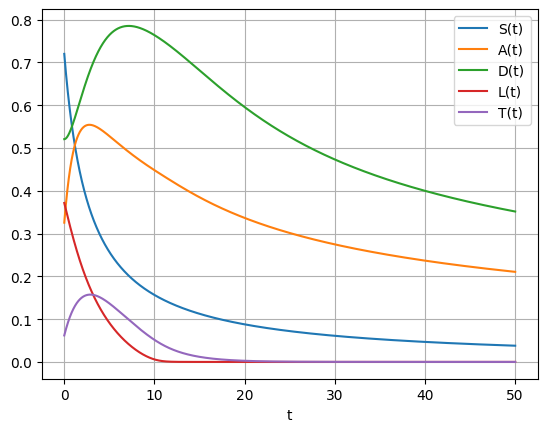

In [21]:
plt.plot(t, x)
plt.grid()
plt.legend(['S(t)', 'A(t)', 'D(t)', 'L(t)', 'T(t)'])
plt.xlabel('t')

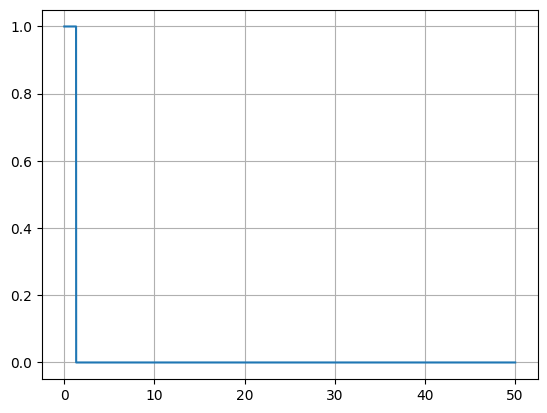

In [10]:
plt.plot(t, u)
plt.grid()
plt.legend('u(t)')
plt.xlabel('t')